# News Headlines Sentiment

Using the news api we pull the latest news articles for bitcoin and ethereum and create a DataFrame of sentiment scores for each coin. 

We will then use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from datetime import datetime, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from newsapi.newsapi_client import NewsApiClient
analyzer = SentimentIntensityAnalyzer()
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\TinkerBell\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Read wer api key environment variable
load_dotenv()

True

In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=os.environ["News_API"])

In [4]:
# Fetch news articles on the topics we passed as list 
def get_crypto_news(coins, ndays):
    articles={}
    today = pd.Timestamp.now(tz="America/Chicago").isoformat()
    today = datetime.strptime(today[:10], "%Y-%m-%d")
    # fetch news articles as of yesterday. Depending on when the program is run, news articles might not yet be published for today 
    to_day = today - timedelta(days=1)  
    from_date = today - timedelta(days=ndays) # n number of days from from yesterday
    for coin in coins:
            news_articles = newsapi.get_everything(q = coin, 
                                                   from_param = from_date.isoformat(),
                                                   to = to_day.isoformat(),
                                                   language = "en",
                                                   sort_by = "relevancy",
                                                   page = 1)
            
            
            news_articles = news_articles['articles']
            articles[coin] = [article['content'] for article in news_articles]
                
    return articles

In [5]:
# Fetch the news articles by passing a list currencies and number of days of news articles to be fethced
coins=['Bitcoin', 'Ethereum']
ndays = 15 
crypto_news = get_crypto_news(coins, ndays)

In [6]:
# load the articiles into DataFrame & drop nulls (there may be some days with no news articles on the topics we want to fetch)
crypto_news_df = pd.DataFrame(crypto_news).dropna().drop_duplicates().reset_index(drop=True)
crypto_news_df.head()

,Bitcoin,Ethereum
0,By Reuters Staff\r\nLONDON (Reuters) - Bank of...,Breitling is partnering with Arianee to issue ...
1,By Reuters Staff\r\nLONDON (Reuters) - Bank of...,Portions of the global economy melted down in ...
2,By Reuters Staff\r\nLONDON (Reuters) - Britain...,Amazon is treating Prime members to an onslaug...
3,Portions of the global economy melted down in ...,"Not a CWT, as he will be interviewing me, but ..."
4,"If there's one thing that John McAfee loves, i...","October\r\n13, 2020\r\n7 min read\r\nOpinions ..."


In [7]:
#Initializing Sentiment Analyzer instance
sent_analyzer = SentimentIntensityAnalyzer()

In [8]:
# define a function to get sentiment scores from the news articles
def get_sentiment_score(news):
    """ Returns a a dicctionary of 2 Dataframes with Sentiment scores and the news articles of each crypto currency"""
    scores={}
    for coin in news.columns:
        scores[coin] = pd.DataFrame(sent_analyzer.polarity_scores(news[coin][i]) for i in range(len(news[coin])))
        scores[coin][coin + '_News'] = news[coin]
    return scores

In [9]:
# call the sentiment score function 
sentiment_score = get_sentiment_score(crypto_news_df)
btc_score_df = sentiment_score['Bitcoin']
eth_score_df = sentiment_score['Ethereum']
#optional -- clenaing up the data removing Reuters Headers 
btc_score_df['Bitcoin_News'] = btc_score_df['Bitcoin_News'].str.replace("By Reuters Staff\r\n", "")
#bitcoin dataframe
btc_score_df.head()

,neg,neu,pos,compound,Bitcoin_News
0,0.035,0.905,0.060,0.2500,LONDON (Reuters) - Bank of England Governor An...
1,0.035,0.905,0.060,0.2500,LONDON (Reuters) - Bank of England Governor An...
2,0.094,0.840,0.066,-0.2732,LONDON (Reuters) - Britains financial watchdog...
3,0.132,0.783,0.085,-0.4215,Portions of the global economy melted down in ...
4,0.072,0.744,0.184,0.6249,"If there's one thing that John McAfee loves, i..."


In [10]:
#Ethereum Dataframe
eth_score_df.head()

,neg,neu,pos,compound,Ethereum_News
0,0.000,1.000,0.000,0.0000,Breitling is partnering with Arianee to issue ...
1,0.132,0.783,0.085,-0.4215,Portions of the global economy melted down in ...
2,0.000,0.954,0.046,0.1779,Amazon is treating Prime members to an onslaug...
3,0.000,0.751,0.249,0.9120,"Not a CWT, as he will be interviewing me, but ..."
4,0.057,0.866,0.078,0.1779,"October\r\n13, 2020\r\n7 min read\r\nOpinions ..."


In [11]:
# Describe the Bitcoin Sentiment
btc_score_df.describe(include=np.number)

,neg,neu,pos,compound
count,17.000000,17.000000,17.000000,17.000000
mean,0.048412,0.899882,0.051765,0.013871
std,0.040486,0.073075,0.050323,0.326030
min,0.000000,0.744000,0.000000,-0.493900
25%,0.000000,0.878000,0.000000,-0.273200
50%,0.046000,0.891000,0.060000,0.000000
75%,0.075000,0.930000,0.066000,0.250000
max,0.132000,1.000000,0.184000,0.624900


In [12]:
# Describe the Ethereum Sentiment
eth_score_df.describe(include=np.number)

,neg,neu,pos,compound
count,17.000000,17.000000,17.000000,17.000000
mean,0.022176,0.889882,0.088000,0.217594
std,0.044656,0.096049,0.097072,0.455339
min,0.000000,0.722000,0.000000,-0.631000
25%,0.000000,0.788000,0.000000,0.000000
50%,0.000000,0.909000,0.050000,0.177900
75%,0.000000,0.954000,0.132000,0.648600
max,0.132000,1.000000,0.278000,0.912000


### Questions:

Q: Which coin had the highest mean positive score?

A: Ethereum haas the highest mean positive score

Q: Which coin had the highest compound score?

A: Ethereum had hte highest compound score of 0.91 and mean compound score of 0.139

Q. Which coin had the highest positive score?

A: Ethereum had the highest positive score of 0.278

---

# Tokenizer

In this section, we will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [13]:
#NLTK imports
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [14]:
#instatiating Lemmatizer
lemmatizer = WordNetLemmatizer()

In [15]:
# Expand the default stopwords list if necessary
sw = set(stopwords.words('english'))
sw_addon = {'said', 'london (reuters) - ', 'tokyo (reuters) - ', 'also', 'reuters', 'could','would'}
sw_union = sw.union(sw_addon)

In [16]:
# Complete the tokenizer function
def tokenizer(text, swu):
    """Tokenizes text."""
    regex = re.compile("[^a-zA-Z ]")
    reg_clean = regex.sub('', text)
    t_word=word_tokenize(reg_clean)
    first_pass= [word.lower() for word in t_word if word.lower() not in swu]
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in first_pass if len(word)>2]
    return tokens

In [17]:
#loading the tokens in to corresponding dataframes. Use the dictionary object to loop through the dfs 
for coin in sentiment_score:
    sentiment_score[coin][coin+'_tokens']=[tokenizer(sentiment_score[coin][column][i], sw_union) 
                        for column in sentiment_score[coin].columns
                       if '_News' in column for i in range(len(sentiment_score[coin]))]
btc_score_df = sentiment_score['Bitcoin']
eth_score_df = sentiment_score['Ethereum']

In [18]:
#Ethereum DataFrame with tokens
btc_score_df.head()

,neg,neu,pos,compound,Bitcoin_News,Bitcoin_tokens
0,0.035,0.905,0.060,0.2500,LONDON (Reuters) - Bank of England Governor An...,"[london, bank, england, governor, andrew, bail..."
1,0.035,0.905,0.060,0.2500,LONDON (Reuters) - Bank of England Governor An...,"[london, bank, england, governor, andrew, bail..."
2,0.094,0.840,0.066,-0.2732,LONDON (Reuters) - Britains financial watchdog...,"[london, britains, financial, watchdog, tuesda..."
3,0.132,0.783,0.085,-0.4215,Portions of the global economy melted down in ...,"[portions, global, economy, melted, emerging, ..."
4,0.072,0.744,0.184,0.6249,"If there's one thing that John McAfee loves, i...","[theres, one, thing, john, mcafee, loves, bath..."


In [19]:
#bitcoin dataframe with tokens
eth_score_df.head()

,neg,neu,pos,compound,Ethereum_News,Ethereum_tokens
0,0.000,1.000,0.000,0.0000,Breitling is partnering with Arianee to issue ...,"[breitling, partnering, arianee, issue, new, k..."
1,0.132,0.783,0.085,-0.4215,Portions of the global economy melted down in ...,"[portions, global, economy, melted, emerging, ..."
2,0.000,0.954,0.046,0.1779,Amazon is treating Prime members to an onslaug...,"[amazon, treating, prime, members, onslaught, ..."
3,0.000,0.751,0.249,0.9120,"Not a CWT, as he will be interviewing me, but ...","[cwt, interviewing, likely, discussion, knows,..."
4,0.057,0.866,0.078,0.1779,"October\r\n13, 2020\r\n7 min read\r\nOpinions ...","[october, min, readopinions, expressed, entrep..."


---

# NGrams and Frequency Analysis

In this section we will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [20]:
from collections import Counter
from nltk import ngrams

In [21]:
# Generate the Bitcoin N-grams where N=2
btc_bigrams = ngrams(tokenizer(' '.join(btc_score_df['Bitcoin_News']), sw_union), n=2)
btc_bigram_counts = Counter(btc_bigrams)
btc_bigram_counts.most_common(10)

[(('bitcoin', 'btc'), 3),
 (('new', 'york'), 3),
 (('london', 'bank'), 2),
 (('bank', 'england'), 2),
 (('england', 'governor'), 2),
 (('governor', 'andrew'), 2),
 (('andrew', 'bailey'), 2),
 (('bailey', 'monday'), 2),
 (('monday', 'hard'), 2),
 (('hard', 'see'), 2)]

In [22]:
# Generate the Ethereum N-grams where N=2
eth_bigrams = ngrams(tokenizer(' '.join(eth_score_df['Ethereum_News']), sw_union), n=2)
eth_bigram_counts = Counter(eth_bigrams)
eth_bigram_counts.most_common(10)

[(('chars', 'amazon'), 2),
 (('amazon', 'treating'), 2),
 (('treating', 'prime'), 2),
 (('prime', 'members'), 2),
 (('members', 'onslaught'), 2),
 (('onslaught', 'deals'), 2),
 (('deals', 'officially'), 2),
 (('officially', 'prime'), 2),
 (('prime', 'day'), 2),
 (('day', 'one'), 2)]

In [23]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    tokens = [tokens[i][j] for i in range(len(tokens)) for j in range(len(tokens[i]))]
    return Counter(tokens).most_common(N)

In [24]:
# Get the top 10 words for Bitcoin
btc_tokens = btc_score_df['Bitcoin_tokens']
btc_top_words = token_count(btc_tokens)
btc_top_words

[('chars', 17),
 ('bitcoin', 7),
 ('bank', 5),
 ('financial', 5),
 ('twitter', 5),
 ('currencies', 4),
 ('london', 3),
 ('btc', 3),
 ('price', 3),
 ('new', 3)]

In [25]:
# Get the top 10 words for Ethereum
eth_tokens = eth_score_df['Ethereum_tokens']
eth_top_words = token_count(eth_tokens)
eth_top_words

[('chars', 17),
 ('ethereum', 9),
 ('one', 5),
 ('prime', 4),
 ('crypto', 4),
 ('many', 4),
 ('new', 3),
 ('ethereums', 3),
 ('network', 3),
 ('innovation', 3)]

# Word Clouds

In this section, we will generate word clouds for each coin to summarize the news for each coin

In [26]:
#wordcloud imports
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 8.0]

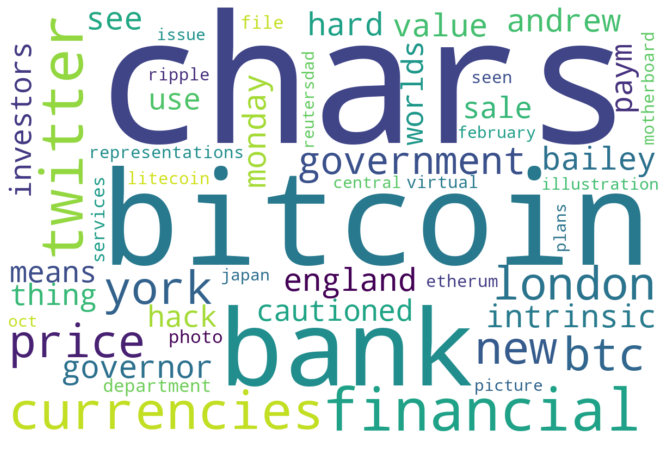

In [27]:
#create Bitcoin wordcloud
btc_news_string=' '.join(btc_score_df['Bitcoin_News'])
wc = WordCloud(width=1200, height=800, max_words=50, background_color="white", collocations=False).generate(' '.join(tokenizer(btc_news_string, sw_union)))
plt.title = "Bitcoin Word Cloud"
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

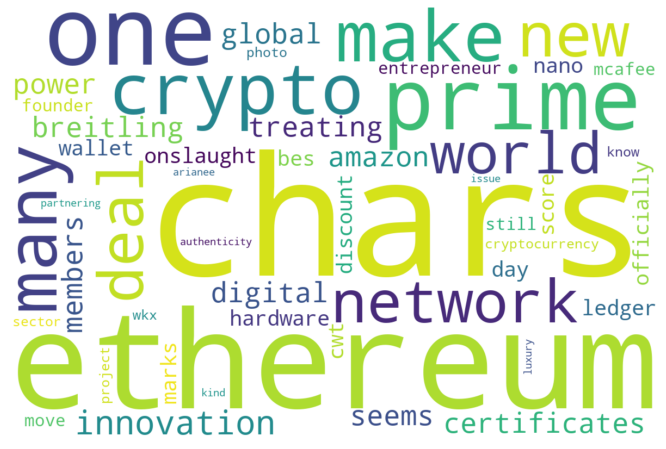

In [28]:
# Generate the Ethereum word cloud
eth_news_string = ' '.join(eth_score_df['Ethereum_News'])
wc = WordCloud(width=1200, height=800, max_words=50, background_color="white", collocations=False).generate(' '.join(tokenizer(eth_news_string, sw_union)))
plt.title ="Ethereum Word Cloud"
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

# Named Entity Recognition

In this section, we will build a named entity recognition model for both coins and visualize the tags using SpaCy.

In [29]:
import spacy
from spacy import displacy

In [30]:
# if language model for spacy was not dowloaded, we can download using:
# !python -m spacy download en_core_web_sm

In [31]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Bitcoin NER

In [32]:
# Concatenate all of the bitcoin text together
btc_news_string = ' '.join(btc_score_df['Bitcoin_News'])
btc_news_string

"LONDON (Reuters) - Bank of England Governor Andrew Bailey said on Monday it was hard to see how Bitcoin BTC= had any intrinsic value and he cautioned over its use as a means of paym… [+420 chars] LONDON (Reuters) - Bank of England Governor Andrew Bailey said on Monday it was hard to see how Bitcoin BTC= had any intrinsic value and he cautioned over its use as a means of paym… [+420 chars] LONDON (Reuters) - Britains financial watchdog said on Tuesday it will ban the sale to retail investors of products that track the price of cryptoassets like Bitcoin, saying most pe… [+1603 chars] Portions of the global economy melted down in 2020, but an emerging asset class seems to have reinforced its staying power amid the chaos.\r\nGrayscale Investments, the world's largest digital-currency… [+5397 chars] If there's one thing that John McAfee loves, it's bath salts. If there are two things? Well, that would be failing to disclose he was paid to promote initial coin offerings on Twitter.\xa0\r\nS

In [33]:
# Run the NER processor on all of the text
btc_doc = nlp(btc_news_string)
btc_doc.user_data["title"] = "Bitcoin NER"

In [34]:
# Render the visualization
displacy.render(btc_doc, style='ent')

In [35]:
# List all Entities
for ent in btc_doc.ents:
    print(ent.text, ent.label_)

LONDON GPE
Reuters ORG
Bank of England ORG
Andrew Bailey PERSON
Monday DATE
Bitcoin GPE
LONDON GPE
Reuters ORG
Bank of England ORG
Andrew Bailey PERSON
Monday DATE
Bitcoin GPE
LONDON GPE
Reuters ORG
Britains NORP
Tuesday DATE
Bitcoin GPE
2020 DATE
Grayscale Investments ORG
one CARDINAL
John McAfee PERSON
two CARDINAL
Twitter ORG
this summer DATE
Twitter ORG
the New York State Department of Financial Services ORG
NYSDFS ORG
Twitter ORG
The New York Department of Financial Services ORG
Julys GPE
Bitcoin GPE
Twitter ORG
Twitter ORG
Bitcoin GPE
Etherum GPE
Litecoin GPE
February 13, 2018 DATE
Bitcoin GPE
Etherum GPE
Litecoin GPE
February 13, 2018 DATE
bitcoin BTC FAC
UK GPE
the Financial Conduct Authority ORG
FCA ORG
October DATE
12 DATE
2020 DATE
2 CARDINAL
Spanish NORP
AI GPE
ul><li PERSON
The People's Bank of China ORG
Asian Currency News ORG
Reuters ORG
Oct 9 DATE
Reuters ORG
Japan GPE
Oct 9 DATE
Reuters ORG
Japan GPE
Friday DATE
a couple of years ago DATE
ol><li GPE
Introduction ORG
Pr

---

## Ethereum NER

In [36]:
# Concatenate all of the bitcoin text together
eth_news_string = ' '.join(eth_score_df['Ethereum_News'])
eth_news_string

"Breitling is partnering with Arianee to issue a new kind of certificates of authenticity for its luxury watches. Instead of relying on physical certificates, the watchmaker gives you a unique digital… [+1593 chars] Portions of the global economy melted down in 2020, but an emerging asset class seems to have reinforced its staying power amid the chaos.\r\nGrayscale Investments, the world's largest digital-currency… [+5397 chars] Amazon is treating Prime members to an onslaught of deals now that it's officially Prime Day. One discount could score you the Ledger Nano S crypto hardware wallet for just $39.99. That marks the bes… [+1487 chars] Not a CWT, as he will be interviewing me, but likely a discussion too, who knows what I may fling back at him?\r\nWhat do you all recommend I read to prepare?\xa0 I prepared a great deal for my CWT with V… [+195 chars] October\r\n13, 2020\r\n7 min read\r\nOpinions expressed by Entrepreneur contributors are their own.\r\nEven as the crypto industry ha

In [37]:
# Run the NER processor on all of the text
eth_doc = nlp(btc_news_string)
eth_doc.user_data["title"] = "Ethereum NER"

In [38]:
# Render the visualization
displacy.render(eth_doc, style='ent')

In [39]:
# List all Entities
for ent in eth_doc.ents:
    print(ent.text, ent.label_)

LONDON GPE
Reuters ORG
Bank of England ORG
Andrew Bailey PERSON
Monday DATE
Bitcoin GPE
LONDON GPE
Reuters ORG
Bank of England ORG
Andrew Bailey PERSON
Monday DATE
Bitcoin GPE
LONDON GPE
Reuters ORG
Britains NORP
Tuesday DATE
Bitcoin GPE
2020 DATE
Grayscale Investments ORG
one CARDINAL
John McAfee PERSON
two CARDINAL
Twitter ORG
this summer DATE
Twitter ORG
the New York State Department of Financial Services ORG
NYSDFS ORG
Twitter ORG
The New York Department of Financial Services ORG
Julys GPE
Bitcoin GPE
Twitter ORG
Twitter ORG
Bitcoin GPE
Etherum GPE
Litecoin GPE
February 13, 2018 DATE
Bitcoin GPE
Etherum GPE
Litecoin GPE
February 13, 2018 DATE
bitcoin BTC FAC
UK GPE
the Financial Conduct Authority ORG
FCA ORG
October DATE
12 DATE
2020 DATE
2 CARDINAL
Spanish NORP
AI GPE
ul><li PERSON
The People's Bank of China ORG
Asian Currency News ORG
Reuters ORG
Oct 9 DATE
Reuters ORG
Japan GPE
Oct 9 DATE
Reuters ORG
Japan GPE
Friday DATE
a couple of years ago DATE
ol><li GPE
Introduction ORG
Pr